# Spatial Adaptive Agglomerative Clustering ($SA^3$)

Author: [Krasen Samardzhiev](https://github.com/u3ks), [Martin Fleischmann](https://github.com/martinfleis)

Spatial Adaptive Agglomerative Clustering ($SA^3$) is a method that extracts regions at multiple scales. It consists of two parts:
1. Computing a full regionalisation tree with any `sklearn.hierarchy.AgglomerativeClustering` algorithm and spatial restrictions imposed by a `libpysal.graph.Graph` or `libpysal.weights.W`
2. Extraction of spatial regions with noise, i.e. some observations will not belong to any of the extracted regions


The algorithm doesn not require to specify the total number of clusters beforehahd. Strictly, it requires only one parameter - the minimum number of spatially contigous observations to form a cluster (`min_cluster_size`). It is inspired by density-based clustering approaches and each resulting region can be interpreted as an approximate mode in the data distribution, given the spatial restrictions imposed by the graph `G` or weights `W`. The final deliniations are:
1. **Contiguous** - observations in the same cluster should be spatially contiguos.
2. **Conservative** - observations are not merged, simply because of spatial restrictions if they are not similar in feature space.
3. **Multiscale** - Sometimes the internal dissimilarity of a specific region is higher than the external dissimilarity of another pair of regions. Even if thats the case the pair of regions are not merged.
4. **Dynamic** - The final number of clusters is inferred from the data based on the `min_cluster_size` parameter and not predefined.


The original application was for the deliniation of morphotopes - contigious areas with identical characteristics and configurations of buildings and streets. These three properties were required since:
1. By definition morphotopes are spatially contiguous
2. There are multiple types of urban fabric interspersed within a city which should be kept seperate - single family houses around apartment blocks, for example.
3. The internal dissimilarity within an industrial area is higher, than the external similarity between a single family housing and a multi-family housing area. Nevertheless, we are interested in getting the three types of coherent units deliniated using one algorithm.
4. We didnt know how many morphotopes to look for.

In [1]:
%config InlineBackend.figure_format = "retina"
%load_ext watermark
%watermark

Last updated: 2025-03-25T13:05:11.987923+01:00

Python implementation: CPython
Python version       : 3.12.9
IPython version      : 9.0.2

Compiler    : GCC 13.3.0
OS          : Linux
Release     : 6.11.0-19-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 24
Architecture: 64bit



In [2]:
import geopandas
import libpysal
from libpysal.examples import load_example
import spopt
import matplotlib.pyplot as plt
import seaborn as sns
from spopt.region import SA3
import numpy as np

%matplotlib inline
%watermark -w
%watermark -iv

Watermark: 2.5.0

numpy     : 2.1.3
spopt     : 0.1.dev1071+g865eacf.d20250324
geopandas : 1.0.1
seaborn   : 0.13.2
matplotlib: 3.10.1
libpysal  : 4.12.1



## Airbnb Spots Clustering in Chicago

To illustrate results and usage the algorihm we use the Airbnb spots data for  Chicago from [libpysal.examples](https://pysal.org/notebooks/lib/libpysal/Example_Datasets.html).

In [ ]:
load_example("AirBnB")
pth = libpysal.examples.get_path("airbnb_Chicago 2015.shp")
chicago = geopandas.read_file(pth)

## $SA^3$ Regionalization

To use the algorithm we have to specify three parameters:
- `gdf`- the feature data for each observation
- `w` - the spatial restrictions on the observations
- `attrs_name` - which features to use for the clustering
- `min_cluster_size` the minimum number of observations, that a cluster should have.

There are also two optional parameters:
- `eom_clusters` which specifies if you should extract the final clusters with the `Excess of Mass` or `Leaf` algorithms.
- `clustering_kwds` which specifies what type of `sklearn.hierarchy.AgglomerativeClustering` should be used.


We show results based on diffent model configurations below.

In all runs we use only  on a single variable - the number of Airbnb spots in each community. Similar to any clustering algorithm, the mode accepts more, but the distribution of one variable is easier to visualise for this demonstration.
We also use the same [spatial weights object](https://pysal.org/libpysal/tutorial.html) which describes the spatial connectivity of the spatial objects.
We change the values for `min_cluster_size`, `eom_clusters` and `clustering_kwds`. 

In [ ]:
attrs_name = ["num_spots"]
w = libpysal.weights.Queen.from_dataframe(chicago, use_index=False)

In [19]:
## first run takes a while, since the functions are compiled to numba

model_eom_3 = SA3(chicago, w, attrs_name, min_cluster_size=3, eom_clusters=True)
model_eom_3.solve()
chicago["sa3_eom_3"] = model_eom_3.labels_

model_leaf_3 = SA3(chicago, w, attrs_name, min_cluster_size=3, eom_clusters=False)
model_leaf_3.solve()
chicago["sa3_leaf_3"] = model_leaf_3.labels_


model_eom_10 = SA3(chicago, w, attrs_name, min_cluster_size=10, eom_clusters=True)
model_eom_10.solve()
chicago["sa3_eom_10"] = model_eom_10.labels_

model_leaf_10 = SA3(chicago, w, attrs_name, min_cluster_size=10, eom_clusters=False)
model_leaf_10.solve()
chicago["sa3_leaf_10"] = model_leaf_10.labels_

Text(0.5, 1.0, 'Leaf extraction, min_clusters=10')

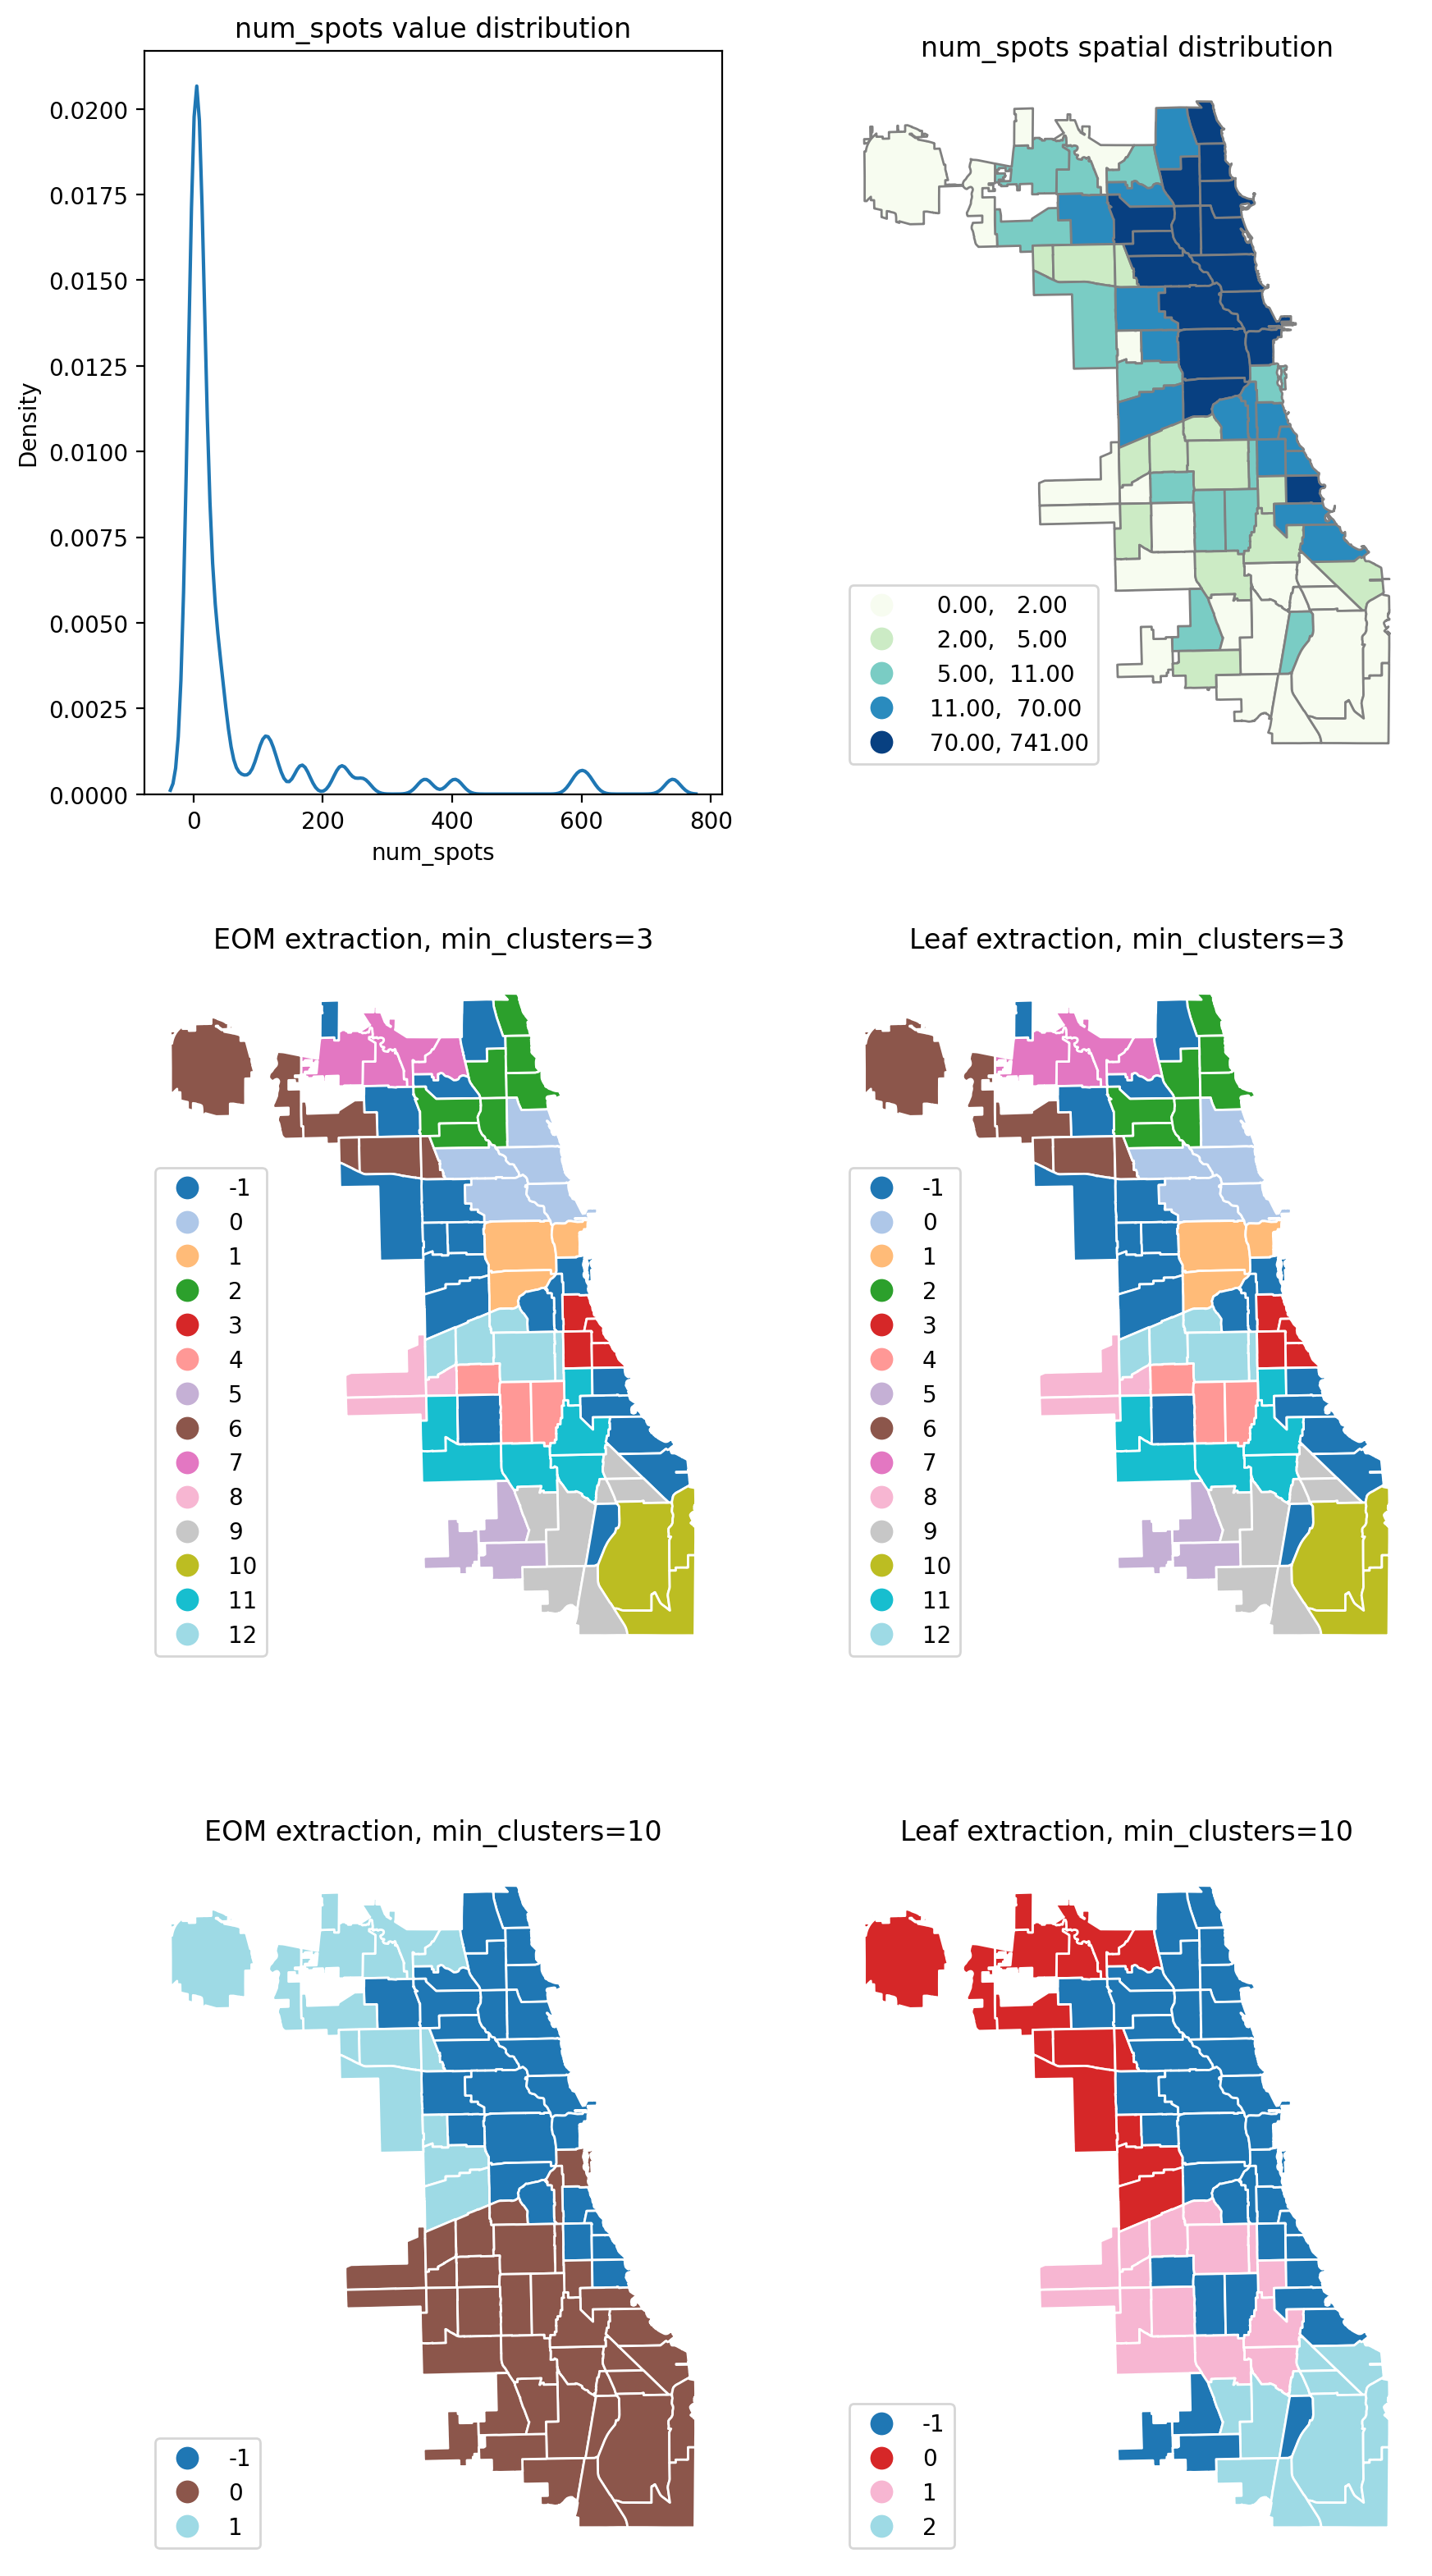

In [20]:
fig, ax = plt.subplots(3, 2, figsize=(10,20))

sns.kdeplot(chicago["num_spots"], bw_adjust = .2, ax=ax[0][0])
ax[0][0].set_title(f'num_spots value distribution')

chicago.plot(
    ax=ax[0][1],
    figsize=(7, 14),
    column="num_spots",
    scheme="Quantiles",
    cmap="GnBu",
    edgecolor="grey",
    legend_kwds={'loc': 'lower left'},
    legend=True
).axis("off")
ax[0][1].set_title(f'num_spots spatial distribution')

chicago.plot(
    ax=ax[1][0], column="sa3_eom_3", categorical=True, edgecolor="w", legend=True, legend_kwds={'loc': 'lower left'}, cmap='tab20'
).axis("off")
ax[1][0].set_title(f'EOM extraction, min_clusters=3')

chicago.plot(
    ax=ax[1][1],
    figsize=(7, 14), column="sa3_leaf_3", categorical=True, edgecolor="w", legend=True, legend_kwds={'loc': 'lower left'}, cmap='tab20'
).axis("off")
ax[1][1].set_title(f'Leaf extraction, min_clusters=3')


chicago.plot(
    ax=ax[2][0], column="sa3_eom_10", categorical=True, edgecolor="w", legend=True, legend_kwds={'loc': 'lower left'}, cmap='tab20'
).axis("off")
ax[2][0].set_title(f'EOM extraction, min_clusters=10')

chicago.plot(
    ax=ax[2][1],
    figsize=(7, 14), column="sa3_leaf_10", categorical=True, edgecolor="w", legend=True, legend_kwds={'loc': 'lower left'}, cmap='tab20'
).axis("off")
ax[2][1].set_title(f'Leaf extraction, min_clusters=10')

In [10]:
chicago[["sa3_eom_3", "num_spots"]].groupby(by="sa3_eom_3").describe()

num_spots                                                        \
              count        mean         std    min     25%    50%     75%   
sa3_eom_3                                                                   
-1             19.0   24.578947   25.902200    0.0    6.50   21.0   35.50   
 0              5.0  541.000000  157.786248  358.0  404.00  593.0  609.00   
 1              3.0  220.000000   49.789557  165.0  199.00  233.0  247.50   
 2              7.0  132.714286   49.818719   75.0  106.00  120.0  148.50   
 3              4.0   31.750000    8.808140   20.0   27.50   34.0   38.25   
 4              3.0    9.333333    1.527525    8.0    8.50    9.0   10.00   
 5              3.0    4.000000    3.605551    0.0    2.50    5.0    6.00   
 6              5.0    4.800000    2.167948    2.0    4.00    5.0    5.00   
 7              4.0    6.750000    3.403430    2.0    5.75    7.5    8.50   
 8              3.0    1.000000    1.000000    0.0    0.50    1.0    1.50   
 9              7.0    0.428571    0.534522    0.0    0.00    0.0    1.00   
 10             3.0    1.333333    1.154701    0.0    1.00    2.0    2.00   
 11             6.0    2.833333    0.752773    2.0    2.25    3.0    3.00   
 12             5.0    4.000000    1.414214    3.0    3.00    3.0    5.00   

                  
             max  
sa3_eom_3         
-1         109.0  
 0         741.0  
 1         262.0  
 2         225.0  
 3          39.0  
 4          11.0  
 5           7.0  
 6           8.0  
 7          10.0  
 8           2.0  
 9           1.0  
 10          2.0  
 11          4.0  
 12          6.0

In [11]:
chicago[["sa3_eom_10", "num_spots"]].groupby(by="sa3_eom_10").describe()

num_spots                                                          
               count        mean         std   min    25%    50%    75%    max
sa3_eom_10                                                                    
-1              26.0  182.807692  200.743821  20.0  39.25  109.5  231.0  741.0
 0              37.0    4.405405    5.459240   0.0   1.00    3.0    6.0   24.0
 1              14.0    7.857143    8.795603   1.0   2.50    6.0    9.5   36.0

In general, increasing the `min_cluster_size` value increases the number of outliers, while decreasing the resolution of the final results. Also changing the extraction to leaf by setting `eom_clusters=False`, sometimes produces more conservative and more numerous clusters.

### Changing agglomeration type.

You can use the any valid combination of linkage, metric and other `sklearn.hierarchy.AgglomerativeClustering` parameters. The default clustering is Ward with Euclidean distance.

In [12]:
for linkage in ['single', 'complete', 'average', 'ward']:
    model = SA3(chicago, w, attrs_name, min_cluster_size=5, eom_clusters=False, clustering_kwds={'linkage': linkage})
    model.solve()
    chicago[f"sa3_leaf_5_{linkage}"] = model.labels_

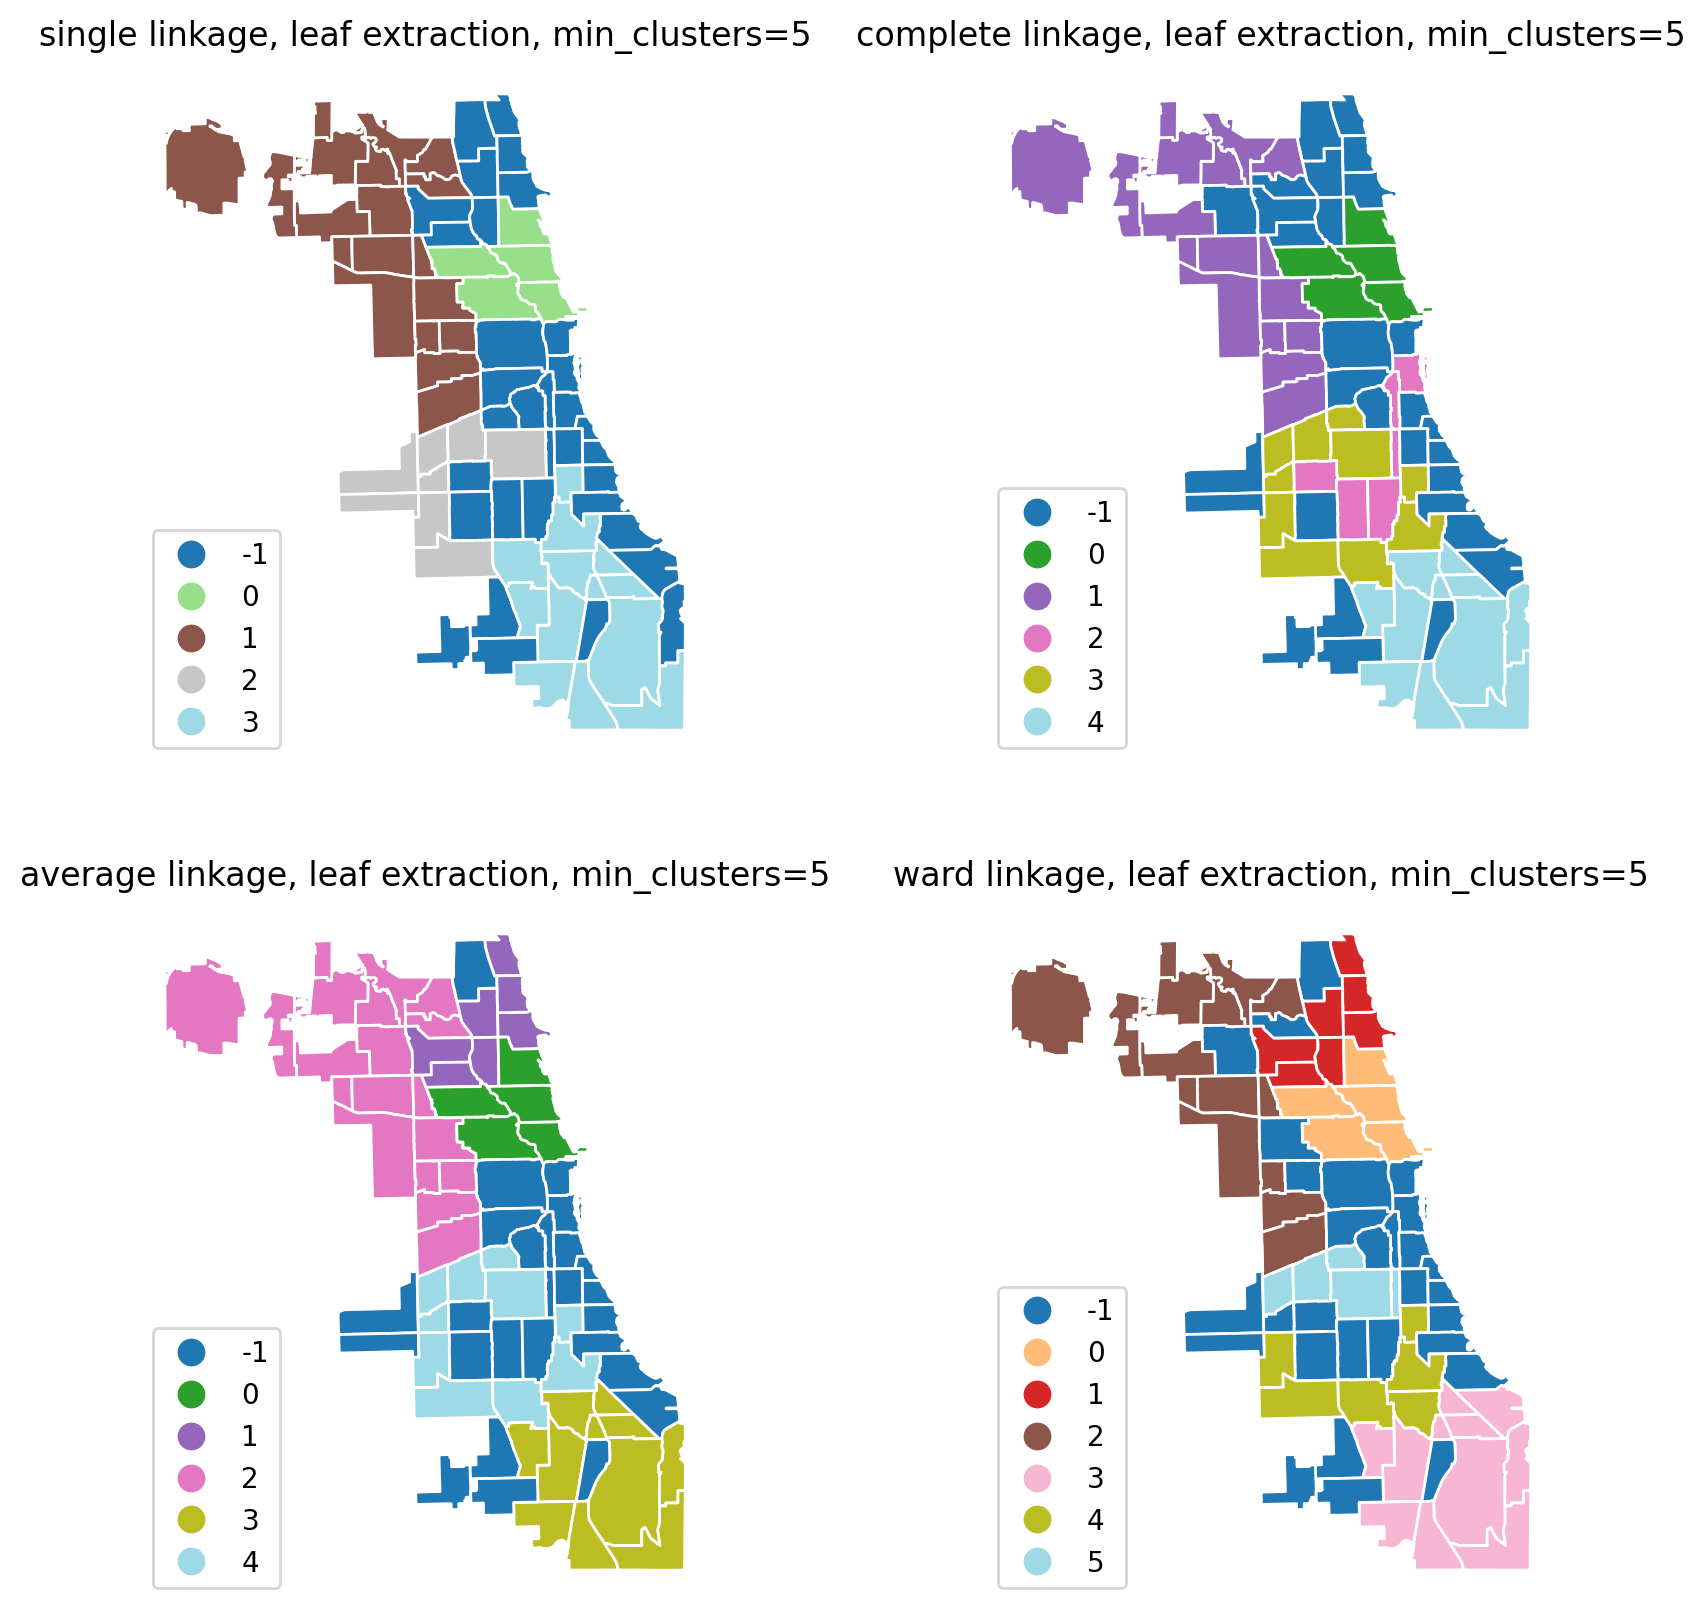

In [13]:
fig, axes = plt.subplots(2, 2, figsize=(10,10))

for linkage, ax in zip(['single', 'complete', 'average', 'ward'], axes.flatten()):

    chicago.plot(
        ax=ax, column=f"sa3_leaf_5_{linkage}", categorical=True, edgecolor="w", legend=True, legend_kwds={'loc': 'lower left'}, cmap='tab20'
    ).axis("off")
    ax.set_title(f'{linkage} linkage, leaf extraction, min_clusters=5')

In [14]:
chicago[["sa3_leaf_5_complete", "num_spots"]].groupby(by="sa3_leaf_5_complete").describe()

num_spots                                                \
                        count        mean         std    min     25%    50%   
sa3_leaf_5_complete                                                           
-1                       29.0   71.034483   77.103587    0.0    7.00   39.0   
 0                        5.0  541.000000  157.786248  358.0  404.00  593.0   
 1                       16.0   10.437500   11.063265    1.0    3.50    7.5   
 2                        6.0    9.000000    2.607681    6.0    7.25    8.5   
 3                       10.0    3.100000    0.875595    2.0    3.00    3.0   
 4                       11.0    0.818182    0.873863    0.0    0.00    1.0   

                                    
                        75%    max  
sa3_leaf_5_complete                 
-1                   110.00  262.0  
 0                   609.00  741.0  
 1                    10.25   36.0  
 2                    10.50   13.0  
 3                     3.00    5.0  
 4                     1.50    2.0

In [15]:
chicago[["sa3_leaf_5_single", "num_spots"]].groupby(by="sa3_leaf_5_single").describe()

num_spots                                                \
                      count        mean         std    min     25%    50%   
sa3_leaf_5_single                                                           
-1                     33.0   62.090909   75.760463    0.0    7.00   24.0   
 0                      5.0  541.000000  157.786248  358.0  404.00  593.0   
 1                     18.0   13.111111   13.118863    1.0    4.25    8.0   
 2                      8.0    2.125000    1.125992    0.0    1.75    2.5   
 3                     13.0    1.461538    1.330124    0.0    0.00    1.0   

                                  
                      75%    max  
sa3_leaf_5_single                 
-1                 109.00  262.0  
 0                 609.00  741.0  
 1                  19.25   40.0  
 2                   3.00    3.0  
 3                   2.00    4.0

### Generic extraction.

You can also directly use the cluster extraction with any valid scipy.hierarchy.linkage_matrix.

In [18]:
from spopt.region import extract_clusters

model = SA3(chicago["num_spots"], w, ["num_spots"], clustering_kwds={'linkage': 'single'})
# bypass the spatial restriction and do simple ward clustering and return a scipy.hierarchy.linkage_matrix
linkage_matrix = model._get_tree(chicago[["num_spots"]], None, model.clustering_kwds)
eom_clusters = extract_clusters(linkage_matrix=linkage_matrix, min_cluster_size=3, eom_clusters=True)

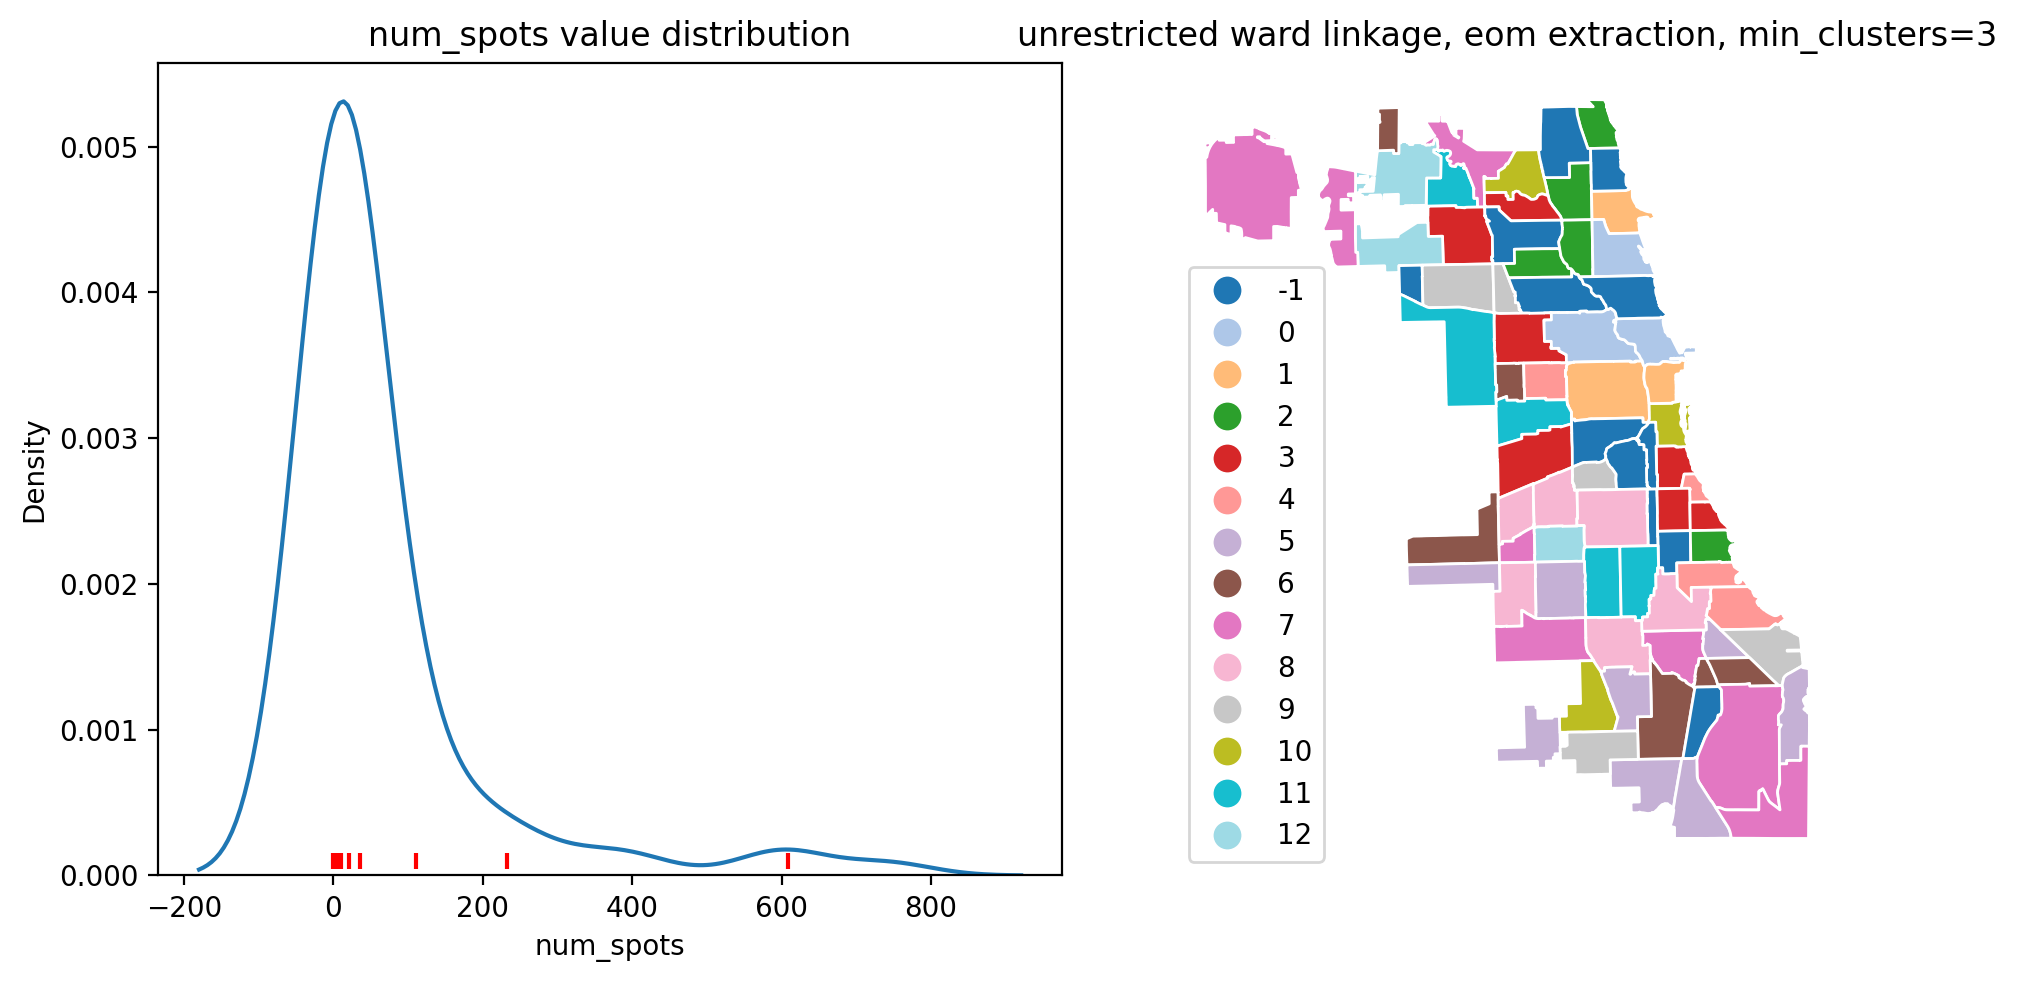

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(10,5))

sns.kdeplot(chicago["num_spots"], ax=ax[0])
xs = chicago["num_spots"].groupby(eom_clusters).median()
ax[0].scatter(xs[xs.index != -1].values, 
              [0.0001] * (xs.index.shape[0] - 1), marker='|', c='red')

ax[0].set_title('num_spots value distribution')

chicago.plot(
        ax=ax[1], column=eom_clusters, categorical=True, edgecolor="w", legend=True, legend_kwds={'loc': 'lower left'}, cmap='tab20'
    ).axis("off")
ax[1].set_title(f'unrestricted ward linkage, eom extraction, min_clusters=3')


fig.tight_layout()


The first image shows the distribution of the num_spots variable, and the red lines show the medians of the clusters. The second image shows the spatial distribution of the clusters, which are not neccasarily contiguous in this case. The underlying idea of cluster extraction as density approximation is more apparent when using `SingleLinkage` and no spatial restrictions.